In [219]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [220]:
folder_path=r"C:\Users\Adeel\Downloads\archive (8)\UTKFace"

In [221]:
import os
age=[]
gender=[]
image_path=[]
for file in os.listdir(folder_path):
    age.append(int(file.split('_')[0]))
    gender.append(int(file.split('_')[1]))
    image_path.append(file)


In [222]:
data=pd.DataFrame({'age':age,
                   'gender':gender,
                   'image_path':image_path
                   })

In [223]:
data.head()

,age,gender,image_path
0,100,0,100_0_0_20170112213500903.jpg.chip.jpg
1,100,0,100_0_0_20170112215240346.jpg.chip.jpg
2,100,1,100_1_0_20170110183726390.jpg.chip.jpg
3,100,1,100_1_0_20170112213001988.jpg.chip.jpg
4,100,1,100_1_0_20170112213303693.jpg.chip.jpg


In [224]:
data.shape


(23708, 3)

In [225]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   age         23708 non-null  int64 
 1   gender      23708 non-null  int64 
 2   image_path  23708 non-null  object
dtypes: int64(2), object(1)
memory usage: 555.8+ KB


In [226]:
train=data.sample(frac=1,random_state=0).iloc[:20000]
test=data.sample(frac=1,random_state=0).iloc[20000:]

In [227]:
train.shape,test.shape

((20000, 3), (3708, 3))

In [228]:
train_data=ImageDataGenerator(
    rescale=1/255,
    rotation_range=30,
    width_shift_range=.2,
    height_shift_range=.2,
    zoom_range=.2,
    shear_range=.2,
    horizontal_flip=True
)
test_data=ImageDataGenerator(rescale=1/255)

In [229]:
train_generator = train_data.flow_from_dataframe(
    train,
    directory=folder_path,
    x_col='image_path',
    y_col=['age', 'gender'],
    target_size=(200, 200),
    class_mode='raw',
    batch_size=32,
    subset="training"  # Training subset
)

val_generator = train_data.flow_from_dataframe(
    test,
    directory=folder_path,
    x_col='image_path',
    y_col=['age', 'gender'],
    target_size=(200, 200),
    class_mode='raw',
    batch_size=32,
    subset="validation"  # Validation subset
)


Found 20000 validated image filenames.
Found 0 validated image filenames.


In [230]:
from keras.applications import VGG16
from keras.layers import *
from keras.models import Model

In [231]:
vggnet=VGG16(include_top=False,input_shape=(200,200,3))

In [232]:
vggnet.trainable=False

output=vggnet.layers[-1].output

flatten=Flatten()(output)

dense1=Dense(512,activation='relu')(flatten)
dense2=Dense(512,activation='relu')(flatten)

dense3=Dense(512,activation='relu')(dense1)
dense4=Dense(512,activation='relu')(dense2)

output1=Dense(1,activation='linear')(dense3)
output2=Dense(1,activation='sigmoid')(dense4)

In [233]:
model=Model(inputs=vggnet.input,outputs=[output1,output2])

In [234]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 200, 200,  │      1,792 │ input_layer_15[0… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 200, 200,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 100, 100,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 100, 100,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 100, 100,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 50, 50,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 50, 50,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 50, 50,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 50, 50,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 25, 25,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 25, 25,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 25, 25,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 25, 25,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 12, 12,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 12, 12,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 12, 12,    │  2,359,808 │ block5_conv1[0][

 Total params: 34,116,418 (130.14 MB)

 Trainable params: 19,401,730 (74.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

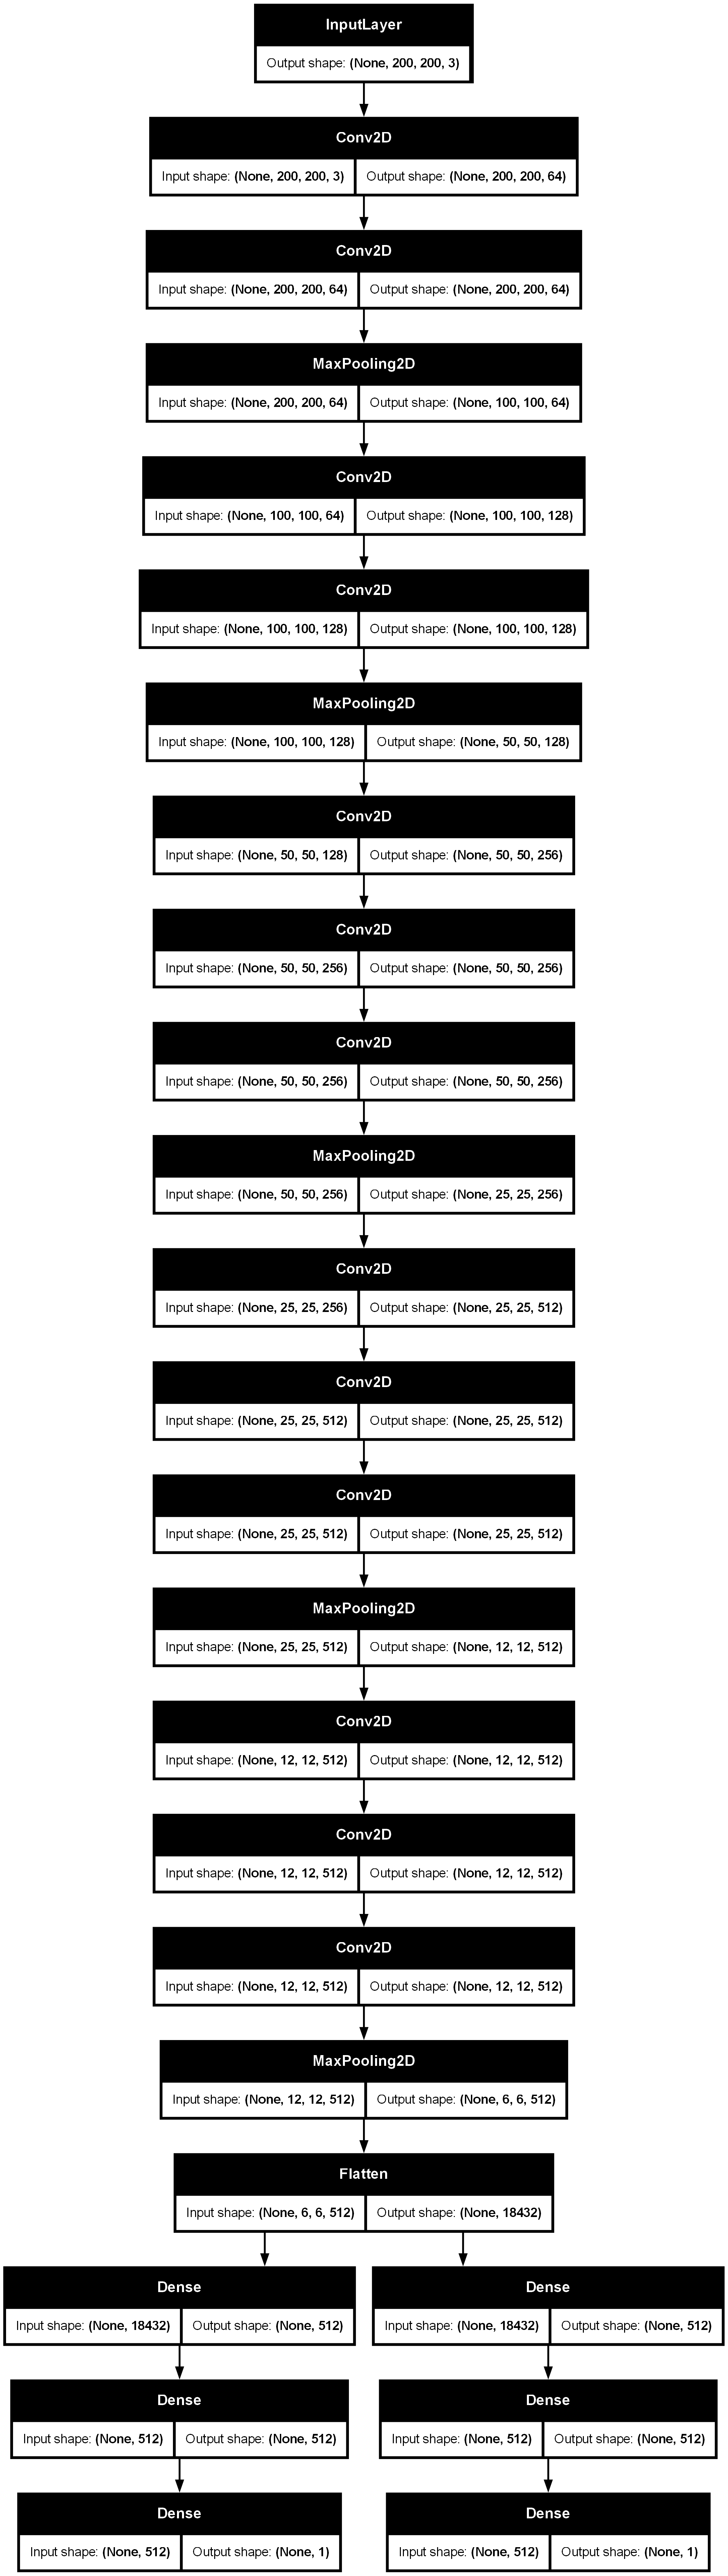

In [235]:
from keras.utils import plot_model
plot_model(model,show_shapes=True)